# Set up

In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install duckdb

Note: you may need to restart the kernel to use updated packages.


In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import duckdb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Get data

For more information about the dataset, please visit this [Link](https://www.kaggle.com/datasets/miadul/e-commerce-sales-transactions-dataset?resource=download)

In [5]:
#Get data

file_path = "ecommerce_sales_34500.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "miadul/e-commerce-sales-transactions-dataset",
  file_path,
)

# Understand the data

## Describe the data

The dataset provides a comprehensive view of customers. The total of 17 columns, 34.5K rows, aggregated by order_id and product_id, gives us the detailed information about customers' transactions. We can categorize the features into three main types:

1. Order Behavior

- Product: Product category, Quantity of each product in an order

- Order value: Unit price of the product, Discounts applied (%), Shipping cost, Total amount (Final bill amount after discounts), Profit Margin (Profit earned from the order)

- Others: Payment method, Return status, Delivery time (in days)

2. Time

Order Date

3. Demographics

Region, Age, Gender

In [6]:
df.head(5)

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
0,O100000,C17270,P234890,Home,164.08,0.15,1,Credit Card,2023-12-23,4,West,No,139.47,7.88,31.17,60,Female
1,O100001,C17603,P228204,Grocery,24.73,0.00,1,Credit Card,2025-04-03,6,South,No,24.73,4.60,-2.62,37,Male
2,O100002,C10860,P213892,Electronics,175.58,0.05,1,Credit Card,2024-10-08,4,North,No,166.80,6.58,13.44,34,Male
3,O100003,C15390,P208689,Electronics,63.67,0.00,1,UPI,2024-09-14,6,South,No,63.67,5.50,2.14,21,Female
4,O100004,C15226,P228063,Home,16.33,0.15,1,COD,2024-12-21,6,East,No,13.88,2.74,1.15,39,Male


In [7]:
df.dtypes

order_id               object
customer_id            object
product_id             object
category               object
price                 float64
discount              float64
quantity                int64
payment_method         object
order_date             object
delivery_time_days      int64
region                 object
returned               object
total_amount          float64
shipping_cost         float64
profit_margin         float64
customer_age            int64
customer_gender        object
dtype: object

I notice that the date is not in datetime format, so I convert it into datetime

In [8]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [9]:
df.isna().sum()

order_id              0
customer_id           0
product_id            0
category              0
price                 0
discount              0
quantity              0
payment_method        0
order_date            0
delivery_time_days    0
region                0
returned              0
total_amount          0
shipping_cost         0
profit_margin         0
customer_age          0
customer_gender       0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

There's no null or duplicated data!

## EDA - Exploratory Analysis

Next, we use the .describe() method to get a quick statistical overview of the data, including the 5-number summary, count, mean, and standard deviation. In addition to this method, we can use other descriptive analysis approaches, such as boxplots or violin plots.

Please note that these methods can only used for numeric data. For categorical data, we will explore further below.

In [11]:
df.describe()

,price,discount,quantity,order_date,delivery_time_days,total_amount,shipping_cost,profit_margin,customer_age
count,34500.000000,34500.000000,34500.000000,34500,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000
mean,119.391632,0.049291,1.490725,2024-09-13 13:39:17.843478272,4.814203,170.008494,6.152120,28.116505,43.474377
min,1.010000,0.000000,1.000000,2023-09-12 00:00:00,3.000000,0.820000,0.000000,-6.200000,18.000000
25%,16.690000,0.000000,1.000000,2024-03-14 00:00:00,4.000000,19.710000,4.420000,1.500000,31.000000
50%,45.660000,0.000000,1.000000,2024-09-16 00:00:00,5.000000,56.820000,6.090000,10.550000,43.000000
75%,130.950000,0.100000,2.000000,2025-03-17 00:00:00,6.000000,168.530000,7.830000,33.132500,56.000000
max,2930.470000,0.300000,5.000000,2025-09-11 00:00:00,13.000000,12931.800000,15.650000,1536.170000,69.000000
std,195.620477,0.069894,0.932270,NaN,1.242141,357.503014,2.389539,53.352947,14.980682


We can see that the dataset covers a timeframe of 2 years from Sep 2023 to Sep 2025. Let's take a closer look at the trend over the time.

### Time attributes

<Axes: title={'center': 'The number of orders by day'}, xlabel='order_date', ylabel='order_cnt'>

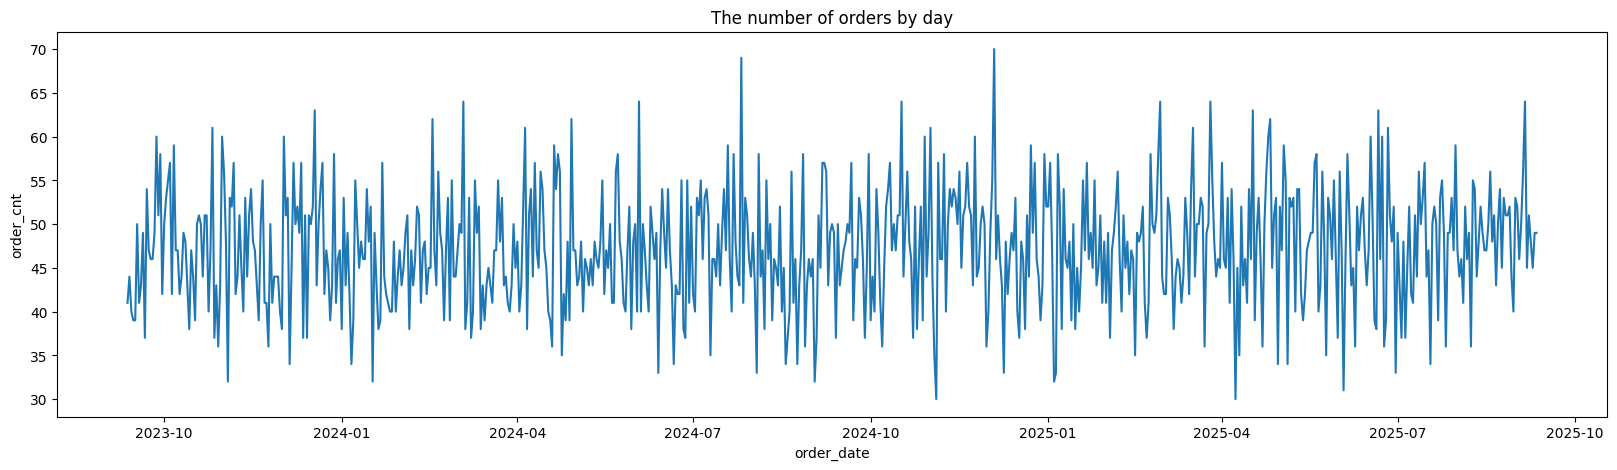

In [12]:
df_time = df.groupby('order_date').agg({'order_id': 'nunique'})
df_time = df_time.rename(columns={'order_id': 'order_cnt'}).reset_index()

plt.figure(figsize=(20, 5))  
plt.title("The number of orders by day")
sns.lineplot(df_time, x = 'order_date', y='order_cnt')

I feel there's some seasonal patterns here. Let's aggregate data by month to make the view clearer.

In [13]:
#Create a month column 

df['month'] = df['order_date'].dt.to_period('M').apply(lambda r: r.start_time)

<Axes: title={'center': 'The number of orders by month'}, xlabel='month', ylabel='order_cnt'>

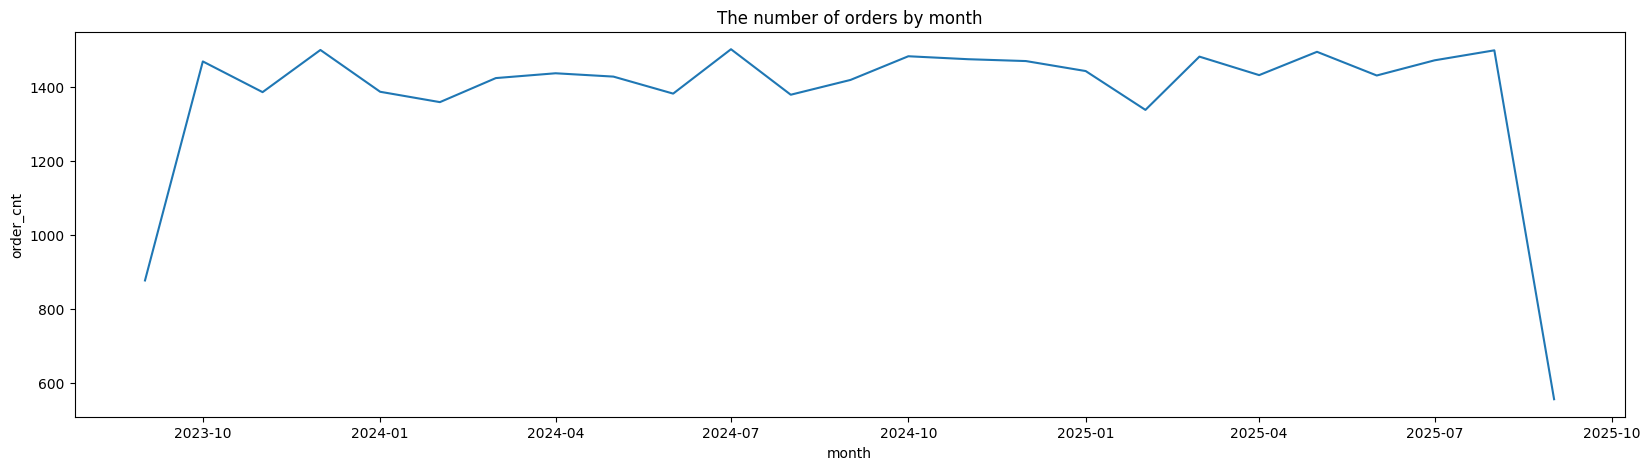

In [14]:
df_time = df.groupby(['month']).agg({'order_id': 'nunique'})
df_time = df_time.rename(columns={'order_id': 'order_cnt'}).reset_index()

plt.figure(figsize=(20, 5))  
plt.title("The number of orders by month")
sns.lineplot(df_time, x = 'month', y='order_cnt')

We observe some peaks in customer activity at the end of the year (likely due to holidays and shopping seasons) and in the middle of the year. However, since we do not know the country context of this dataset, we cannot determine the exact external factors driving these seasonal trends.

Additionally, the data for September 2023 and September 2025 is incomplete, so we will drop these two months from the analysis.

In [15]:
df = df[~df['month'].isin(['2023-09-01','2025-09-01'])]

### Overview about customer buying behaviors

Now, let’s analyze monthly customer activity. Specifically, we will look at:

- The number of active customers each month

- Their total number of orders

- The number of products per order

- The number of categories represented in each order

<Axes: title={'center': 'The number of customers by month'}, xlabel='month', ylabel='customer_cnt'>

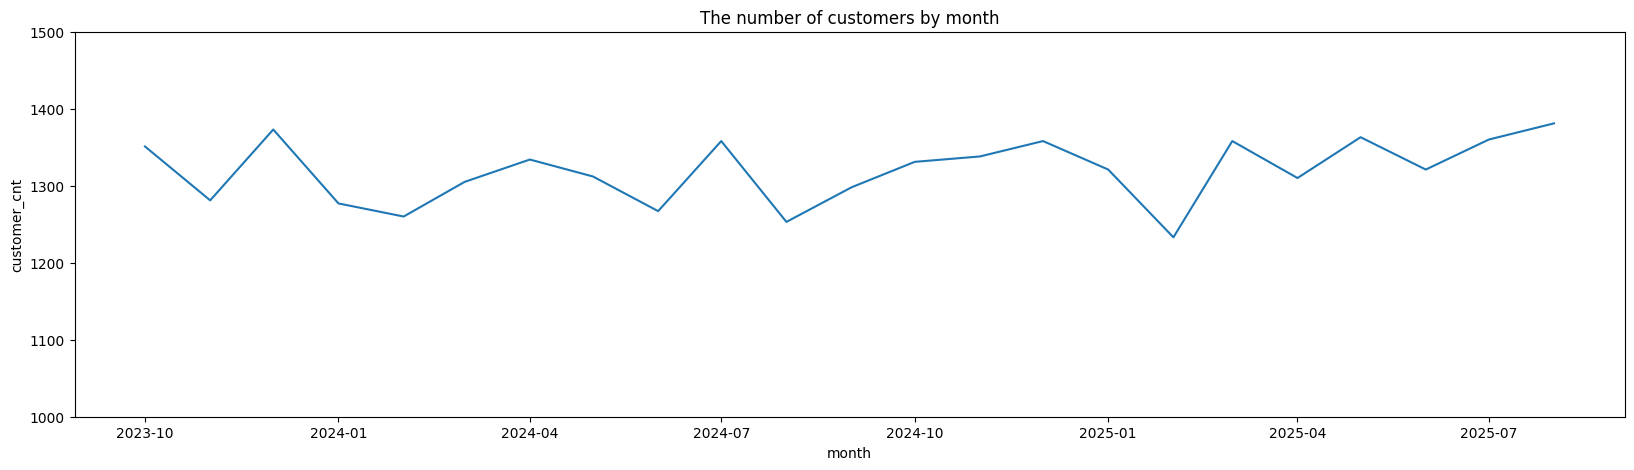

In [16]:
df_time = df.groupby(['month']).agg(customer_cnt = ('customer_id', 'nunique'))

plt.figure(figsize=(20, 5))  
plt.ylim(1000, 1500)
plt.title("The number of customers by month")
sns.lineplot(df_time, x = 'month', y='customer_cnt')

In [17]:
df_order = df.groupby(['month','customer_id']).agg({'order_id': 'nunique'})

df_product = df.groupby(['month','order_id']).agg({'product_id': 'nunique','category': 'nunique'})


In [18]:
df_product.describe()

,product_id,category
count,33069.0,33069.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [19]:
df_order.describe()

,order_id
count,30343.000000
mean,1.089840
std,0.305137
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000


Each customer just orders around 1 order per month and there's only 1 product_id in each order! 

### "Churn users" definition

Let's go down to the main question we want to solve is: **How can we prevent customer churn?**

First, let’s define churn. The definition can vary depending on the industry and the company’s growth stage. For example, some companies may consider a customer “churned” if they are inactive for 1 month, 3 months, or even 6 months. Our task is to determine the appropriate **time window for churn** in our dataset.

To explore this, we will analyze how frequently users place orders by calculating the number of months between their consecutive purchases. This will also help us visualize and define a reasonable formula for churn.

For this calculation, I will use DuckDB to query the data with SQL and compute the necessary metrics.

In [37]:

query = '''
select customer_id
, datediff('month', min(month), max(month)) as tenure
, count(distinct month) as months_active
, coalesce(datediff('month', min(month), max(month)) / (count(distinct month) - 1),0) avg_intervals_between_orders 
from df
group by 1

'''
df_gap = duckdb.query(query).to_df()
df_gap.head(5)

,customer_id,tenure,months_active,avg_intervals_between_orders
0,C17270,11,3,5.500000
1,C10860,9,2,9.000000
2,C15051,22,8,3.142857
3,C16420,11,4,3.666667
4,C11184,19,9,2.375000


In [33]:
df_gap.describe()

,tenure,months_active,avg_gaps_between_orders
count,7881.000000,7881.000000,7285.000000
mean,12.594341,3.850146,5.174868
std,6.352466,1.726695,3.075333
min,0.000000,1.000000,1.000000
25%,8.000000,3.000000,3.250000
50%,14.000000,4.000000,4.333333
75%,18.000000,5.000000,6.000000
max,22.000000,10.000000,22.000000


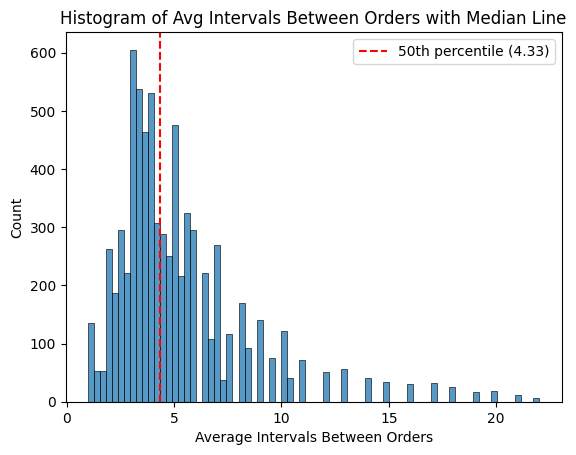

In [38]:
sns.histplot(df_gap, x = 'avg_intervals_between_orders')

median_val = np.nanpercentile(df_gap['avg_intervals_between_orders'], 50)

plt.axvline(median_val, color='red', linestyle='--', label=f'50th percentile ({median_val:.2f})')

plt.legend()
plt.xlabel('Average Intervals Between Orders')
plt.ylabel('Count')
plt.title('Histogram of Avg Intervals Between Orders with Median Line')
plt.show()

If we use the **50th percentile (median)** as the measure of central tendency, we find that a threshold of 4 months is a good representative. This means any customer who does not place an order within the next 4 months can be considered churned. In other words, our definition of churn will capture about 50% of users.

Next, let’s calculate the churn rate based on this threshold.

In [40]:

query = '''
with customer_by_month as 
(select month, customer_id
from df
group by 1,2)

, churn as
(select cm.month
, cm.customer_id
, min(case when df.month between cm.month + interval 1 month and cm.month + interval 4 month then 0 else 1 end) as will_churn
from customer_by_month cm
left join df using (customer_id)
group by 1,2)

select month, count(distinct case when will_churn = 1 then customer_id end)/count(distinct customer_id) as churn_rate
from churn
where month not in ('2025-08-01','2025-07-01','2025-06-01','2025-05-01')
group by 1
order by 1
'''


df_churn = duckdb.query(query).to_df()

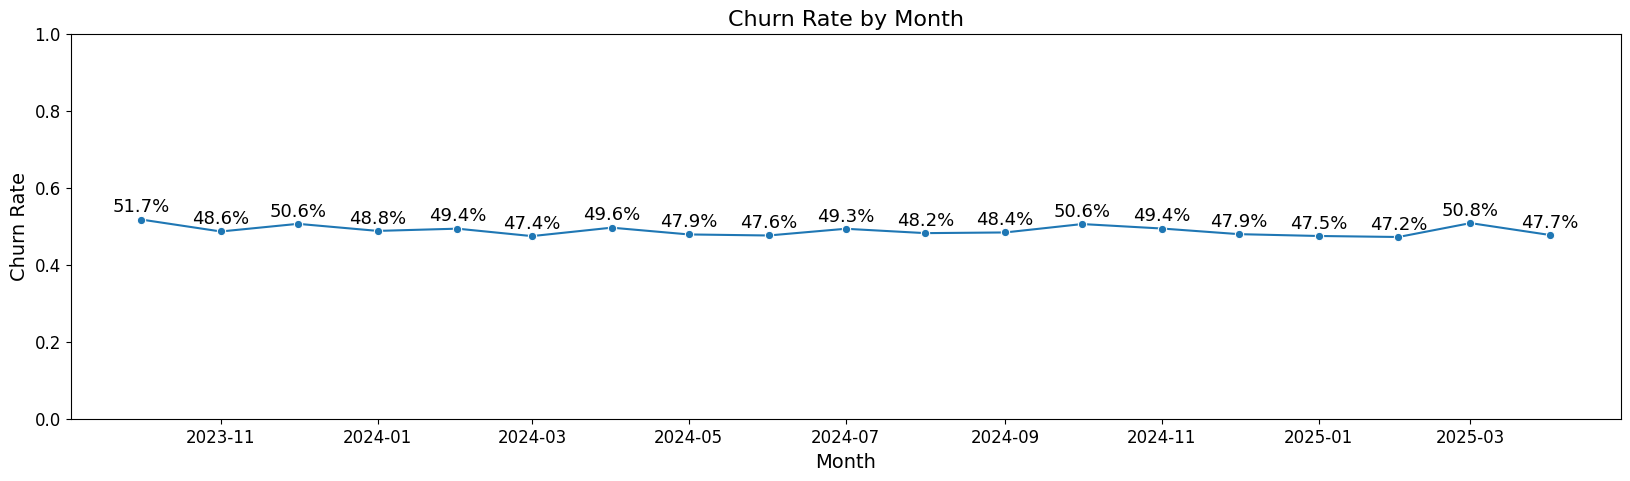

In [44]:
plt.figure(figsize=(20, 5))  
plt.title("Churn Rate by Month", fontsize=16)
plt.ylim(0, 1)
sns.lineplot(data=df_churn, x='month', y='churn_rate', marker='o')

# Add data labels
for i, row in df_churn.iterrows():
    plt.text(row['month'], row['churn_rate'] + 0.01,  # slightly above the point
             f"{row['churn_rate']:.1%}", 
             ha='center', va='bottom', fontsize=13)

plt.xlabel("Month", fontsize=14)  
plt.ylabel("Churn Rate", fontsize=14)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

As expected, churn rate is around 50%

In this project, I will train models using data from January, February, and March 2025. I will then evaluate each model and calculate the average performance metrics to select the best-performing model.

### Correlation Analysis

1. RFM (Recency, Frequency, Monetary)

- **Recency:** Users who have ordered more recently are less likely to churn compared to new users or those who were active long ago.
→ I will define user tenure and check their latest active month.

- **Frequency:** Users with a higher order frequency are less likely to churn.

- **Monetary:** High-value users—those who are willing to spend more (reflected by average order value)—are more likely to stay. These users are typically less price-sensitive, less discount-driven, and tend to purchase higher-priced items.

By analyzing RFM both over the lifetime and in recent months, we can get a broad view of user behavior. Hypothesis: Recent months have a stronger impact on churn probability than lifetime metrics.

2. Other Potential Factors

- **Distance:** Longer delivery distances mean longer waiting times and higher shipping costs, which may reduce user stickiness.

- **Payment Method:** Research suggests there may be correlations between payment methods and customer loyalty. Some methods could indicate stronger trust and retention.

- **Return Rate:** Users with a high return rate may be less loyal. On the other hand, users who have a smooth, trouble-free buying experience are more likely to form positive habits and remain with the platform.

#### Numeric attributes

First, I will examine the relationship between numeric metrics and the probability of churn. To do this, I will use:

- Boxplots to compare the distribution of features between churned and non-churned users

- A correlation matrix to identify linear relationships between numeric variables and churn

In [237]:
query = '''

with customer_by_month as 
(select month, customer_id
from df
group by 1,2)

, churn as
(select cm.month
, cm.customer_id
, min(case when df.month between cm.month + interval 1 month and cm.month + interval 4 month then 0 else 1 end) as will_churn
from customer_by_month cm
left join df using (customer_id)
group by 1,2)

, first_month as
(select customer_id, min(month) as first_month
from df 
group by 1)

, life_time_value as
(select cm.month
, cm.customer_id
, datediff('month', fm.first_month, cm.month) as tenure
, coalesce(datediff('month', max(case when df.month < cm.month then df.month end),cm.month),0) as months_since_latest_order
, count(distinct case when fm.first_month <= cm.month then order_id end) as lifetime_order_cnt
, sum(case when df.month <= cm.month then profit_margin end) as lifetime_profit_margin
, count(distinct case when df.month <= cm.month then df.month end) as months_active
, count(distinct case when fm.first_month <= cm.month then order_id end) / count(distinct case when df.month <= cm.month then df.month end) as orders_per_month
from customer_by_month cm
left join df using(customer_id)
left join first_month fm using(customer_id)
group by 1,2,3)
, 

last_four_month_value as
(select cm.month
, cm.customer_id
, count(distinct case when returned = 'Yes' then order_id end)/count(distinct order_id) as returned_rate_l4m
, count(distinct order_id) as order_cnt_l4m
, avg(price) as avg_product_price_l4m
, sum(discount*price*quantity)/sum(price*quantity) as discount_rate_l4m
, count(distinct case when discount > 0 then order_id end)/count(distinct order_id) as order_with_discount_pct_l4m
, avg(discount) as avg_discount_pct_l4m
, avg(quantity) as avg_quantity_l4m
, avg(total_amount) as avg_total_amount_l4m
, avg(shipping_cost) as shipping_cost_l4m
, avg(profit_margin) as profit_margin_l4m
, avg(delivery_time_days) as avg_deliver_time_days_l4m
from customer_by_month cm
left join df on cm.customer_id = df.customer_id and df.month between cm.month - interval 3 months and cm.month
group by 1,2)
, 
latest_month_value as
(select month
, customer_id
, customer_age
, count(distinct case when returned = 'Yes' then order_id end)/count(distinct order_id) as returned_rate
, count(distinct order_id) as order_cnt
, avg(price) as avg_product_price
, sum(discount*price*quantity)/sum(price*quantity) as discount_rate
, count(distinct case when discount > 0 then order_id end)/count(distinct order_id) as order_with_discount_pct
, avg(discount) as avg_discount_pct
, avg(quantity) as avg_quantity
, avg(total_amount) as avg_total_amount
, avg(shipping_cost) as shipping_cost
, avg(profit_margin) as profit_margin
, avg(delivery_time_days) as avg_deliver_time_days
from df
group by 1,2,3)

select latest_month_value.*, last_four_month_value.*, tenure, months_since_latest_order, lifetime_order_cnt, lifetime_profit_margin, months_active, orders_per_month ,will_churn
from latest_month_value
left join life_time_value using(month,customer_id)
left join churn using(month,customer_id)
left join last_four_month_value using(month,customer_id)
where month between '2025-01-01' and '2025-03-01'

'''


df_explore = duckdb.query(query).to_df()
df_explore.drop(columns = ['month_1', 'customer_id_1'], inplace=True)

In [238]:
df_explore.describe()

,month,customer_age,returned_rate,order_cnt,avg_product_price,discount_rate,order_with_discount_pct,avg_discount_pct,avg_quantity,avg_total_amount,...,shipping_cost_l4m,profit_margin_l4m,avg_deliver_time_days_l4m,tenure,months_since_latest_order,lifetime_order_cnt,lifetime_profit_margin,months_active,orders_per_month,will_churn
count,4253,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,...,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000
mean,2025-01-31 06:17:31.304961024,43.279332,0.050317,1.001646,114.987809,0.049660,0.458265,0.049671,1.475899,158.970369,...,6.084916,26.578037,4.819598,11.276746,4.772161,5.162238,112.838091,3.649659,1.493781,0.489302
min,2025-01-01 00:00:00,18.000000,0.000000,1.000000,1.020000,0.000000,0.000000,0.000000,1.000000,0.940000,...,0.000000,-5.430000,3.000000,0.000000,0.000000,1.000000,-9.430000,1.000000,1.000000,0.000000
25%,2025-01-01 00:00:00,30.000000,0.000000,1.000000,16.490000,0.000000,0.000000,0.000000,1.000000,19.210000,...,4.770000,3.760000,4.000000,9.000000,2.000000,4.000000,36.330000,3.000000,1.166667,0.000000
50%,2025-02-01 00:00:00,43.000000,0.000000,1.000000,44.230000,0.000000,0.000000,0.000000,1.000000,54.780000,...,6.040000,13.490000,5.000000,13.000000,4.000000,5.000000,79.270000,4.000000,1.333333,0.000000
75%,2025-03-01 00:00:00,56.000000,0.000000,1.000000,122.020000,0.100000,1.000000,0.100000,2.000000,156.950000,...,7.390000,33.193333,5.500000,15.000000,7.000000,6.000000,152.080000,5.000000,1.666667,1.000000
max,2025-03-01 00:00:00,69.000000,1.000000,2.000000,2653.170000,0.300000,1.000000,0.300000,5.000000,5276.800000,...,14.500000,618.720000,10.000000,17.000000,17.000000,13.000000,1161.220000,10.000000,6.000000,1.000000
std,NaN,14.905110,0.218625,0.040541,194.721652,0.069734,0.498196,0.069728,0.916143,306.296574,...,2.002675,40.455473,1.055404,4.775222,3.904138,2.039938,112.569799,1.481780,0.531379,0.499944


<Figure size 3000x3000 with 0 Axes>

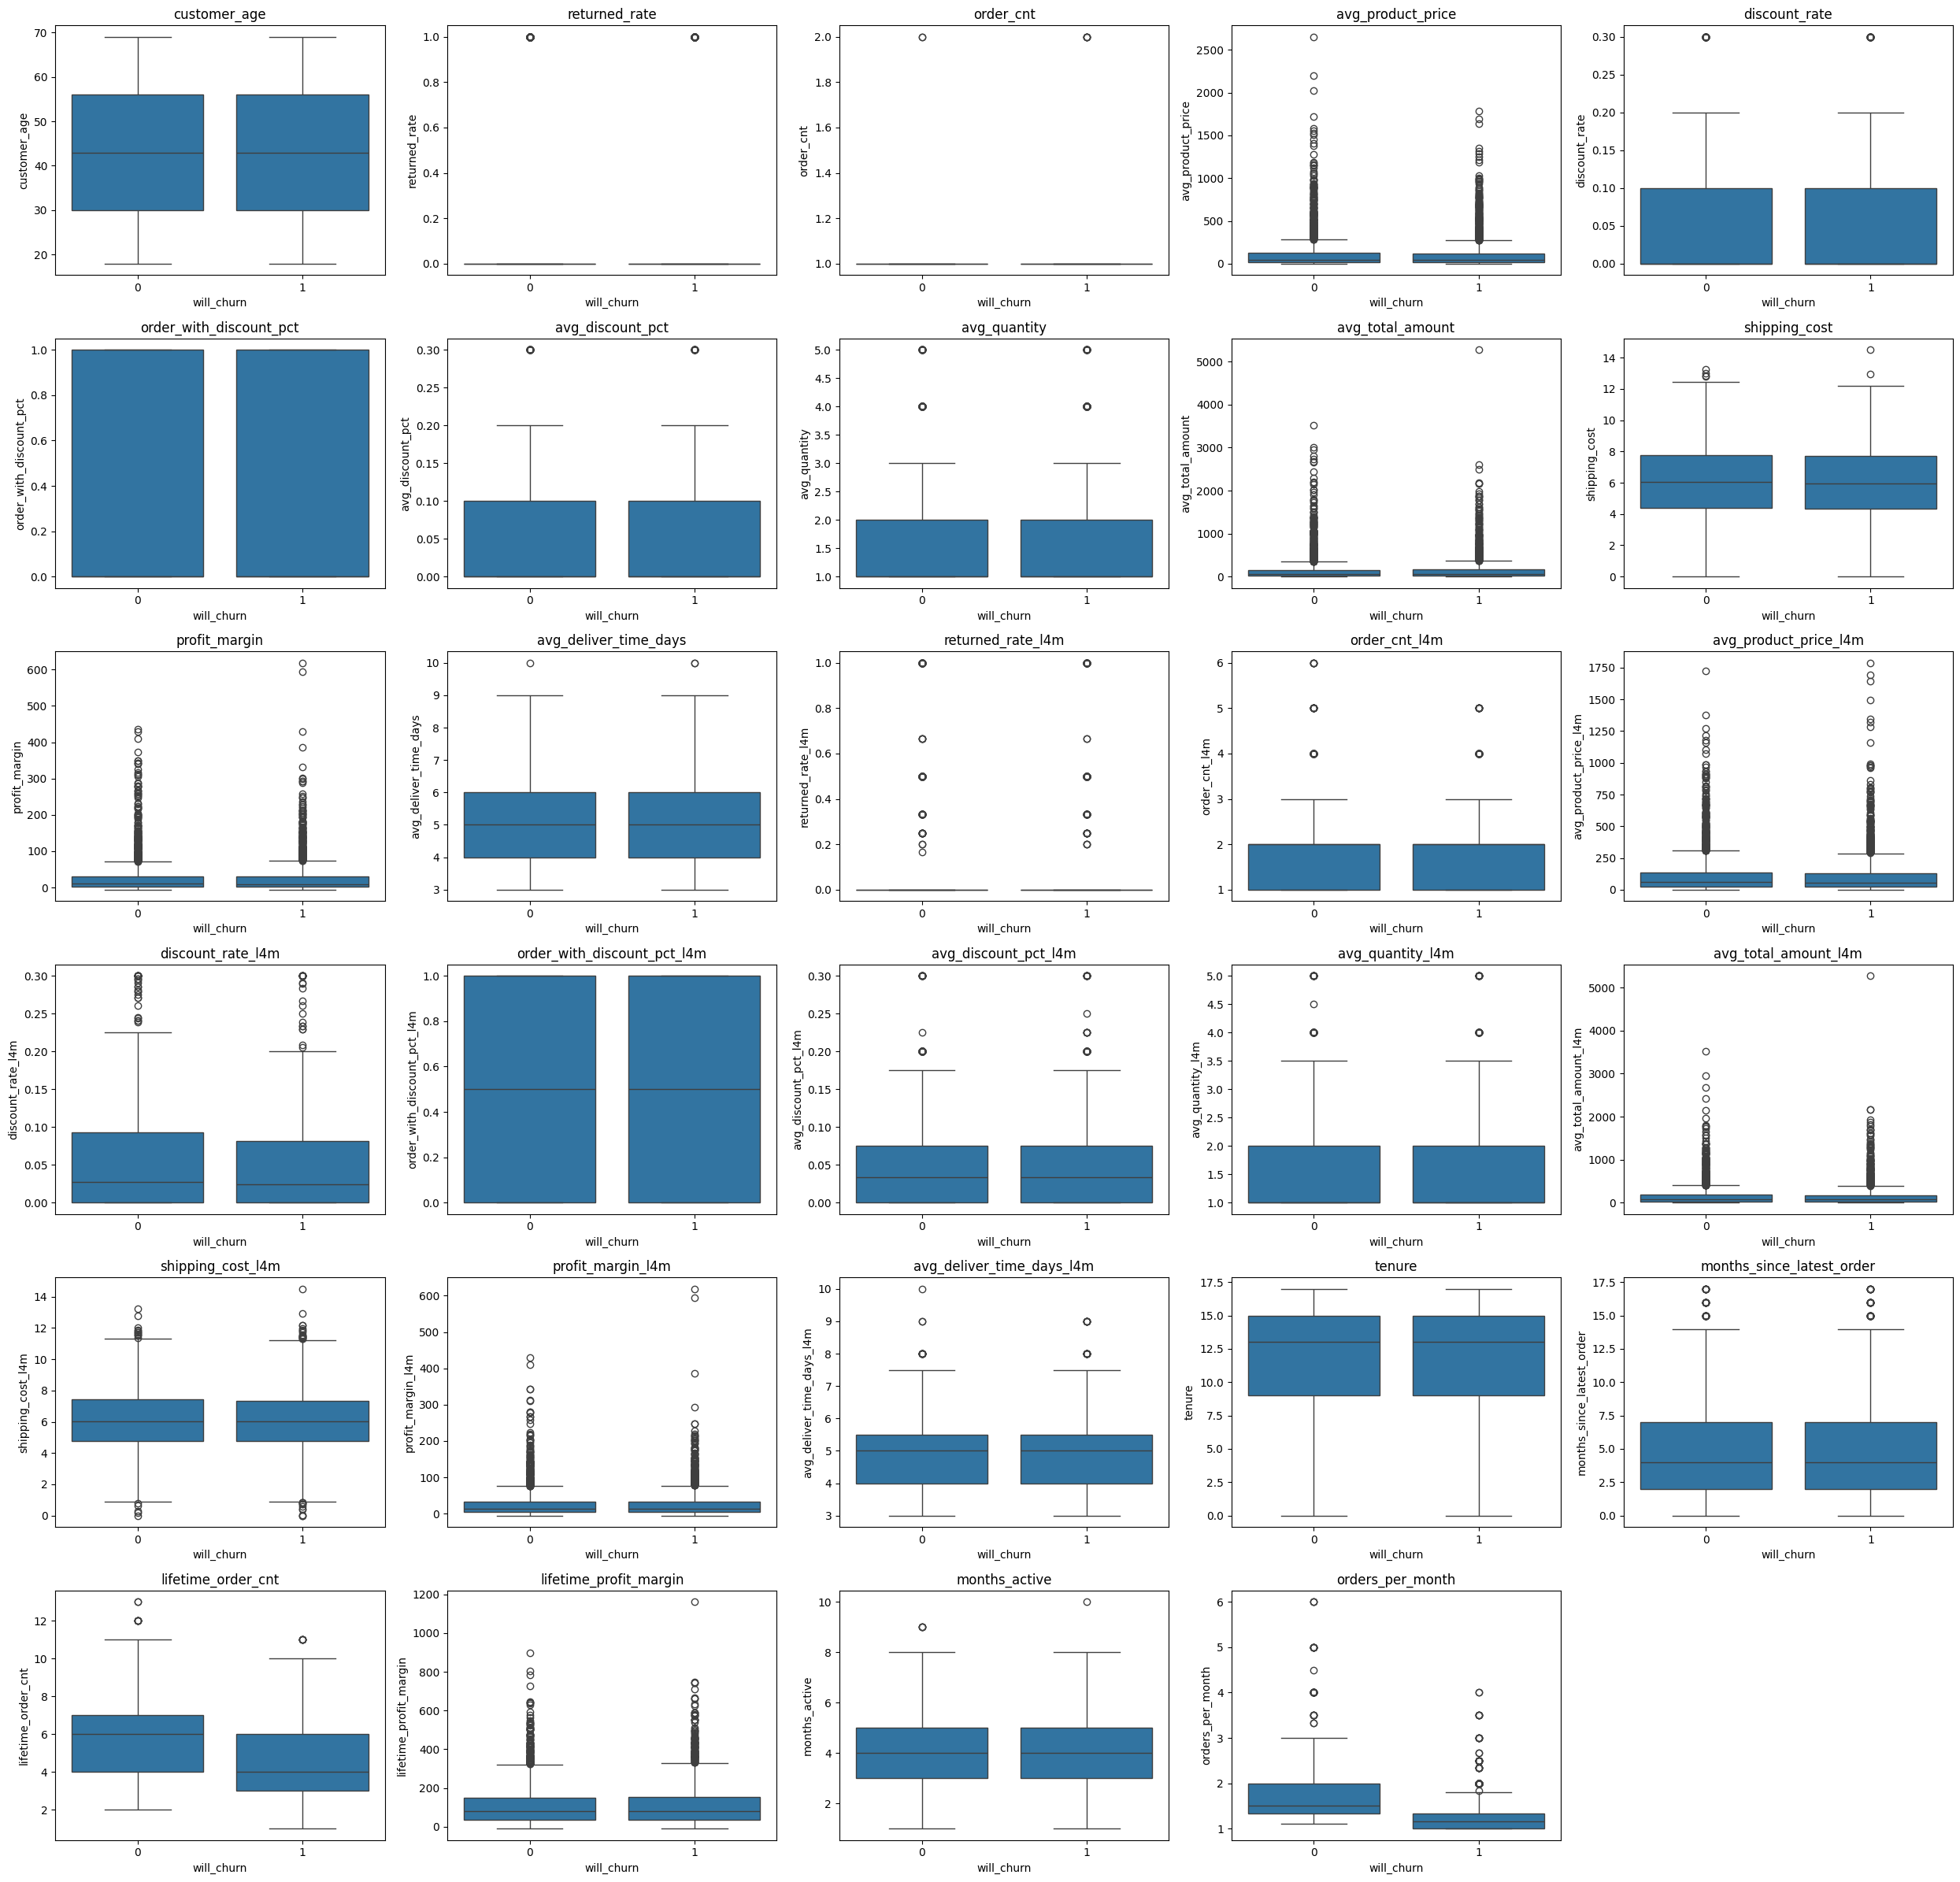

In [239]:
# Assume df is your DataFrame
exclude_cols = ['month', 'customer_id', 'will_churn']
numeric_cols = [c for c in df_explore.columns if c not in exclude_cols]

plt.figure(figsize=(30,30))
# Set up the plot grid
n_cols = 5  # number of subplots per row
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

# Create boxplots
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='will_churn', y=col, data=df_explore, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

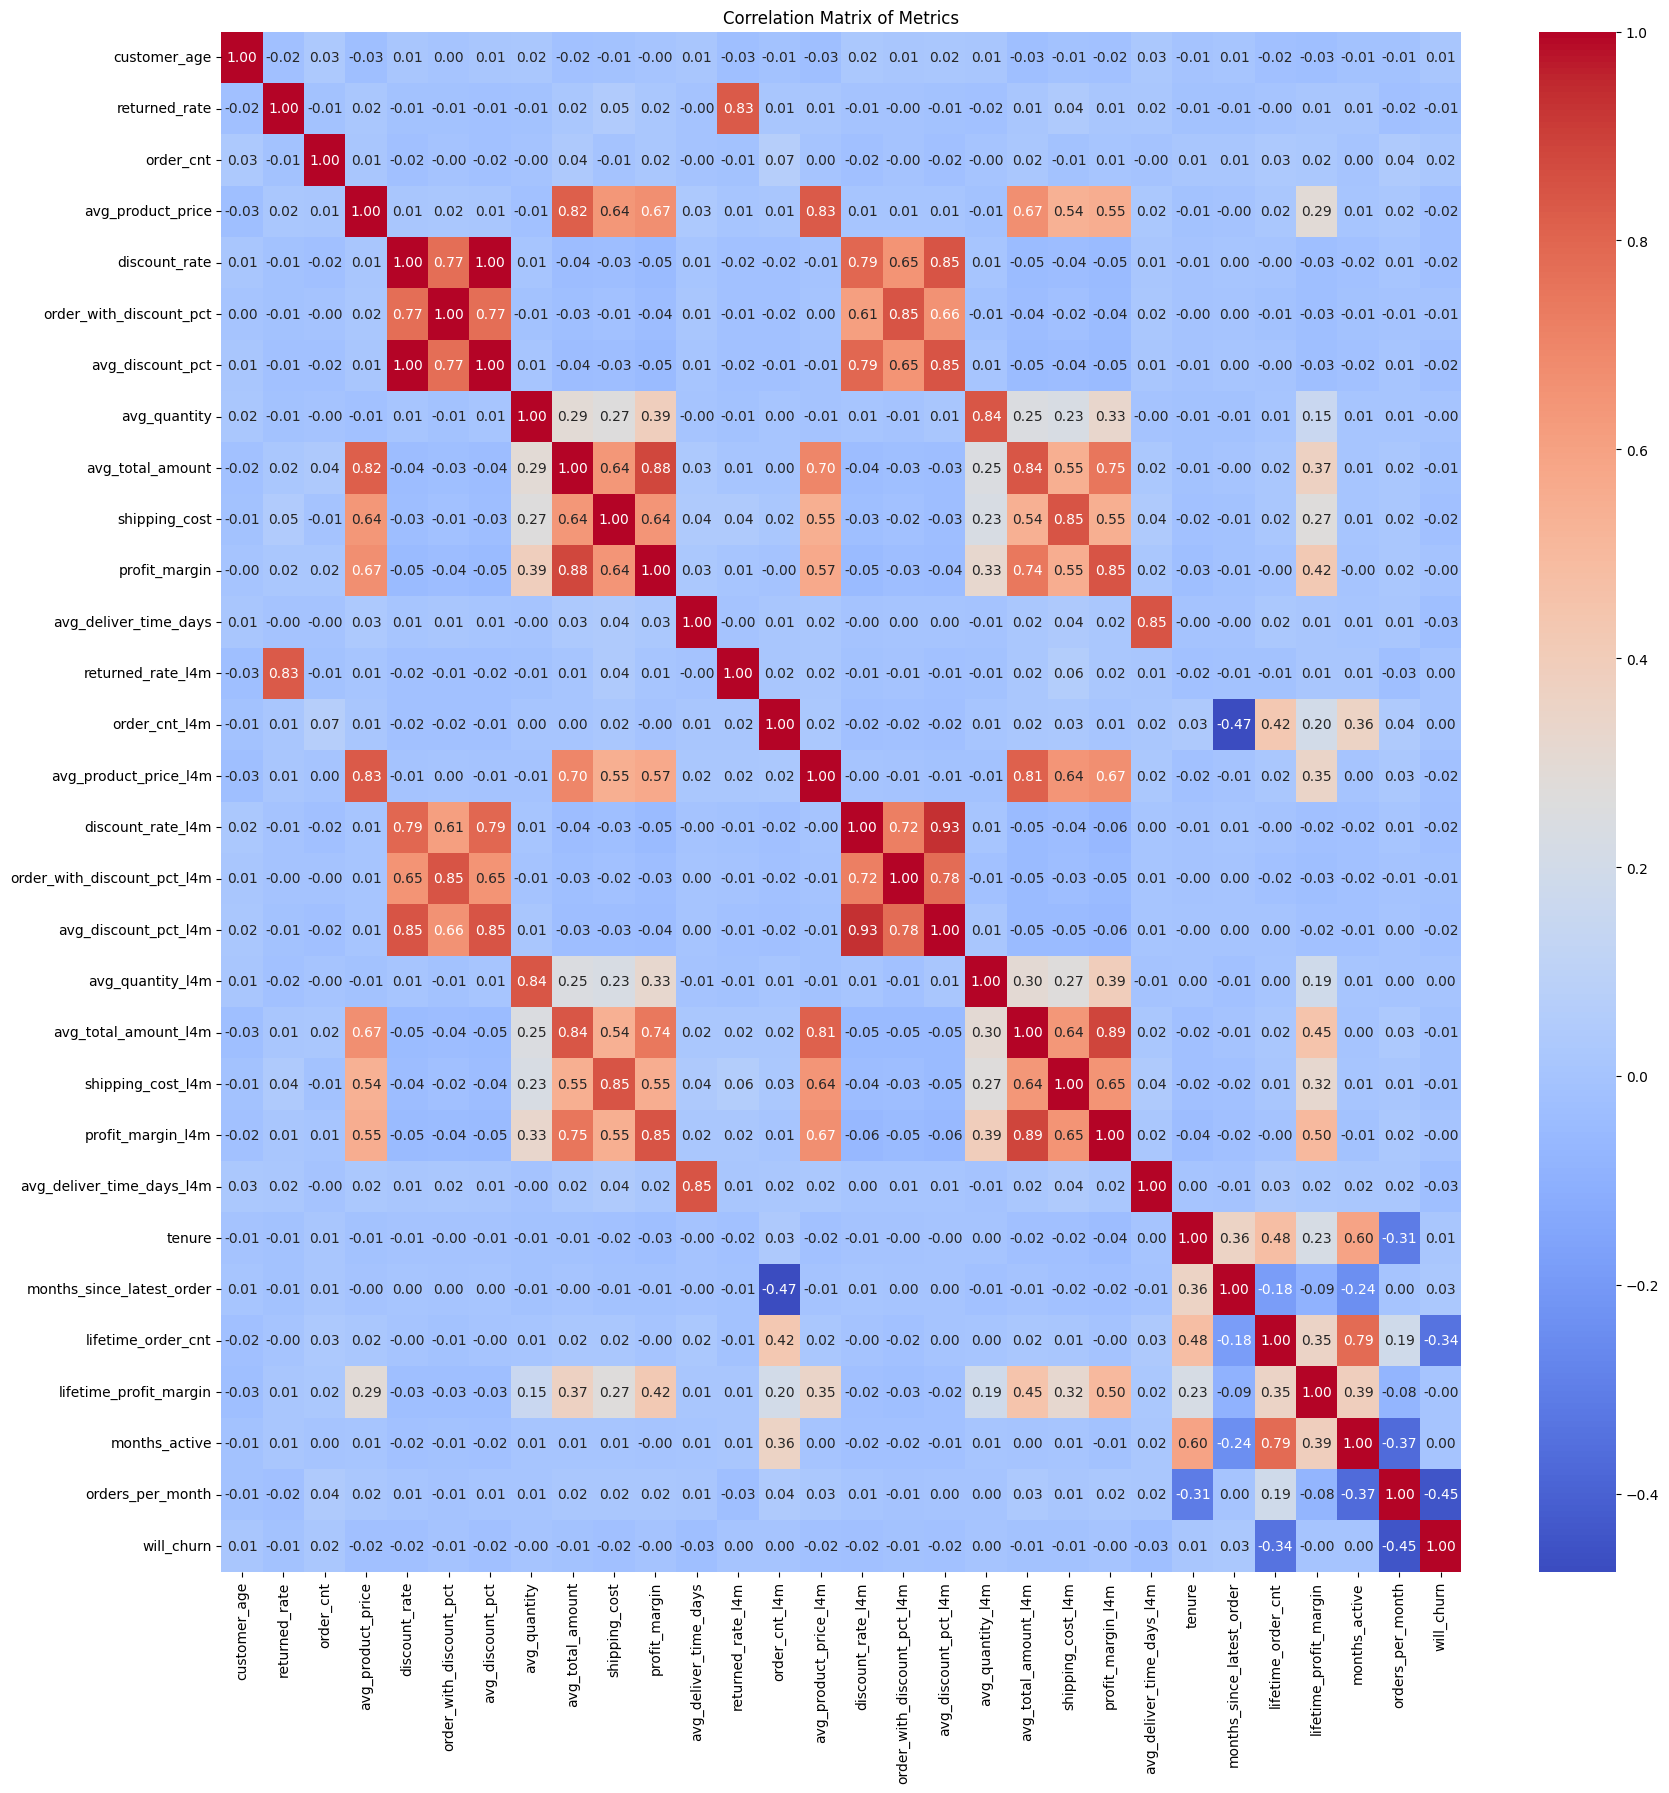

In [240]:
# Exclude non-metrics
exclude_cols = ['month', 'customer_id']
numeric_cols = [c for c in df_explore.columns if c not in exclude_cols]

# Correlation matrix
corr_matrix = df_explore[numeric_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Metrics")
plt.show()


Contrary to my initial hypothesis, lifetime metrics—such as total lifetime orders or average orders per month—show stronger correlations with churn probability than recent activity measures.

#### Categorical attributes

Next, I will visualize the categorical attributes to check whether there are noticeable differences between churned and non-churned groups. I prefer using pivot tables, as they are simple to create and more intuitive for business stakeholders to understand.

In [241]:
query = '''

with customer_by_month as 
(select month, customer_id
from df
group by 1,2)

, churn as
(select cm.month
, cm.customer_id
, min(case when df.month between cm.month + interval 1 month and cm.month + interval 4 month then 0 else 1 end) as will_churn
from customer_by_month cm
left join df using (customer_id)
group by 1,2)

, life_time_value as
(select cm.month
, will_churn
, customer_gender
, category
, region
, payment_method
, count(distinct order_id) as life_time_order_cnt
from customer_by_month cm
left join churn using(month,customer_id)
left join df on cm.customer_id = df.customer_id and df.month <= cm.month
group by 1,2,3,4,5,6)
, 
 
latest_month_value as
(select month
, will_churn
, customer_gender
, category
, region
, payment_method
, count(distinct order_id) as order_cnt
from df
left join churn using(month,customer_id)
group by 1,2,3,4,5,6)

select latest_month_value.*, life_time_order_cnt
from latest_month_value
left join life_time_value using(month,will_churn,customer_gender, category, region, payment_method)
where month between '2025-01-01' and '2025-03-01'

'''


df_category = duckdb.query(query).to_df()
df_category

,month,will_churn,customer_gender,category,region,payment_method,order_cnt,life_time_order_cnt
0,2025-02-01,1,Female,Fashion,North,Debit Card,6,15
1,2025-02-01,1,Male,Electronics,East,Debit Card,3,7
2,2025-01-01,1,Male,Sports,South,Debit Card,2,8
3,2025-02-01,1,Female,Beauty,North,Debit Card,4,11
4,2025-03-01,1,Male,Home,West,Debit Card,1,11
...,...,...,...,...,...,...,...,...
1955,2025-03-01,0,Male,Fashion,North,PayPal,1,2
1956,2025-02-01,1,Female,Toys,Central,UPI,1,2
1957,2025-03-01,1,Male,Beauty,North,Wallet,1,3
1958,2025-03-01,0,Female,Grocery,North,Debit Card,1,6


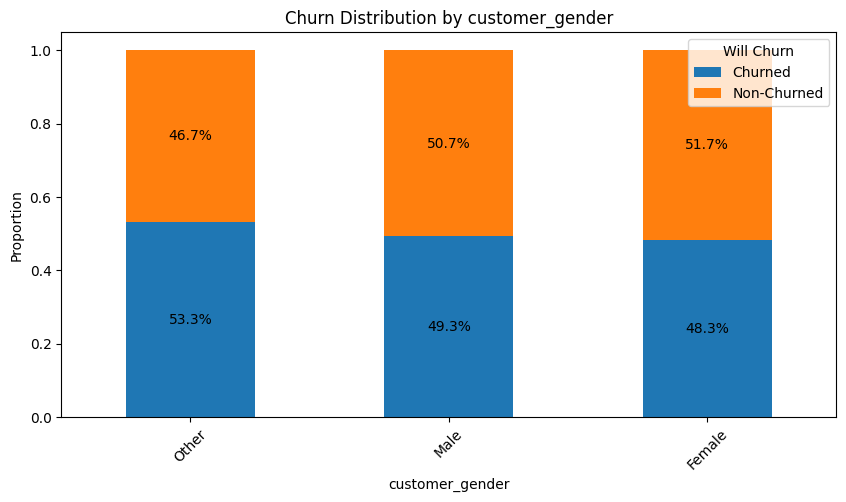

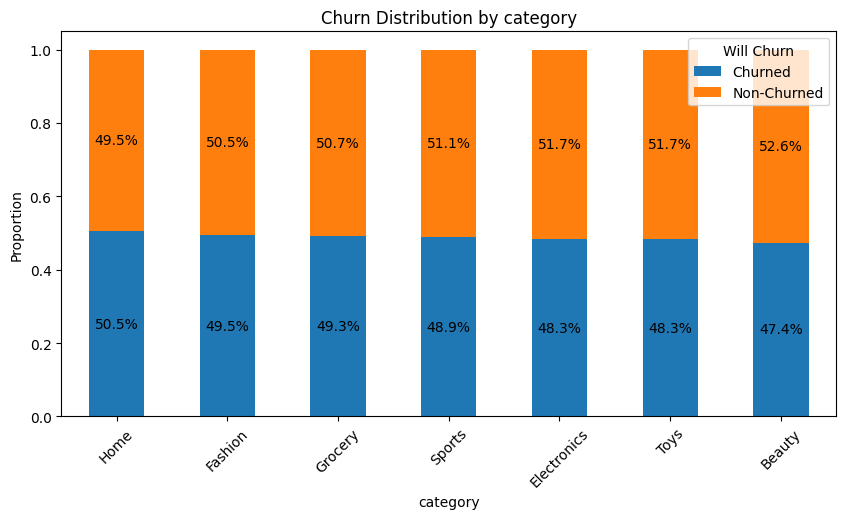

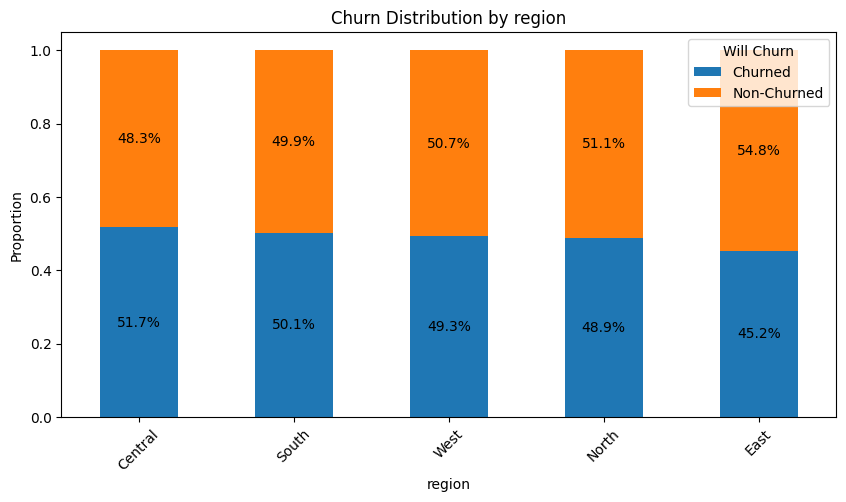

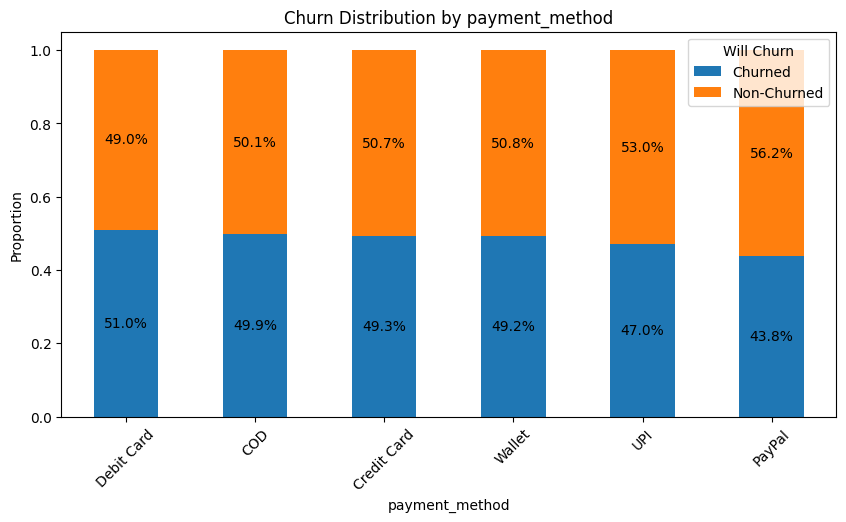

In [300]:
# colors = ['#CBA0E3', '#FFF59D']  # [churn=1, churn=0]

cat_columns = ['customer_gender', 'category', 'region', 'payment_method']

for cat in cat_columns:
    # Pivot table normalized by column
    pivot = pd.crosstab(
        df_category['will_churn'],
        df_category[cat],
        values=df_category['order_cnt'],
        aggfunc='sum',
        normalize='columns'
    ).round(3)
    
    # Transpose for plotting
    pivot_t = pivot.T
    
    # Sort by churn probability (churn=1) descending
    pivot_t = pivot_t.sort_values(by=1, ascending=False)
    pivot_t = pivot_t[[1, 0]]
    
    # Plot stacked bar chart
    ax = pivot_t.plot(kind='bar', stacked=True, figsize=(10, 5))
    
    # Add data labels
    for patch in ax.patches:
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        if height > 0:
            ax.text(
                x + width / 2, 
                y + height / 2, 
                f"{height:.1%}", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='black'
            )
    
    plt.title(f"Churn Distribution by {cat}")
    plt.ylabel("Proportion")
    plt.xlabel(cat)
    plt.legend(title='Will Churn', loc='upper right', labels=['Churned', 'Non-Churned'])
    plt.xticks(rotation=45)
    plt.show()


We can observe the following patterns from the categorical analysis:

- Gender: Other-gender users have a slightly higher churn tendency compared to male and female ones.

- Product Category: Fashion, Home and Grocery are the top three categories with the highest churn probability, suggesting these items may not be purchased regularly.

- Region: Customers in the West and Central regions show higher probabilities of churn, compared to the East.

- Payment Method: Users paying via debit card or COD also tend to churn more frequently, while Paypal users have better stickiness.

# Feature selection

Based on the analysis above, we will build a model using both numeric and categorical features:

1. Numeric Features

- Include RFM metrics and other order behavior metrics from this month, the last 4 months, and lifetime values.
- Product category, region, and payment method: Because a single user can have multiple categories, regions, or payment methods in a month, we will pivot these columns using the order count for the current month as values.

- Since the features are on different scales, we will rescale the data before feeding it into the model.

2. Categorical Features

- Include customer gender

- For customer gender, we will apply one-hot encoding.

First, let's pivot the categorical columns

In [268]:
query = '''

with 
 
latest_month_value as
(select month
, customer_id
, customer_gender
, category
, region
, payment_method
, count(distinct order_id) as order_cnt
from df
group by 1,2,3,4,5,6)

select latest_month_value.*
from latest_month_value
where month between '2025-01-01' and '2025-03-01'

'''


df_category_transpose = duckdb.query(query).to_df()
df_category_transpose

,month,customer_id,customer_gender,category,region,payment_method,order_cnt
0,2025-01-01,C10792,Male,Sports,South,PayPal,1
1,2025-03-01,C14550,Male,Fashion,East,COD,1
2,2025-02-01,C16645,Female,Toys,South,COD,1
3,2025-03-01,C16383,Male,Home,Central,UPI,1
4,2025-03-01,C15373,Male,Toys,East,Debit Card,1
...,...,...,...,...,...,...,...
4253,2025-02-01,C17836,Female,Grocery,Central,COD,1
4254,2025-01-01,C16625,Female,Toys,Central,UPI,1
4255,2025-01-01,C11488,Female,Home,West,COD,1
4256,2025-01-01,C15134,Female,Electronics,South,COD,1


In [269]:
# Create a single "category combination" column
df_category_transpose["combo"] = df_category_transpose["category"].astype(str) + "_" + df_category_transpose["payment_method"].astype(str) + "_" + df_category_transpose["region"].astype(str)

# Pivot to wide format: one column per combination
df_transpose = (
    df_category_transpose.pivot_table(
        index=["month", "customer_id","customer_gender"],
        columns="combo",
        values="order_cnt",
        aggfunc="sum",
        fill_value=0
    )
    .reset_index()
)
df_transpose


combo,month,customer_id,customer_gender,Beauty_COD_Central,Beauty_COD_East,Beauty_COD_North,Beauty_COD_South,Beauty_COD_West,Beauty_Credit Card_Central,Beauty_Credit Card_East,...,Toys_UPI_Central,Toys_UPI_East,Toys_UPI_North,Toys_UPI_South,Toys_UPI_West,Toys_Wallet_Central,Toys_Wallet_East,Toys_Wallet_North,Toys_Wallet_South,Toys_Wallet_West
0,2025-01-01,C10015,Female,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2025-01-01,C10015,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2025-01-01,C10026,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2025-01-01,C10030,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2025-01-01,C10032,Male,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,2025-03-01,C17970,Female,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4101,2025-03-01,C17970,Male,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4102,2025-03-01,C17974,Female,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4103,2025-03-01,C17982,Female,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [270]:
df_final = df_explore.merge(
    df_transpose,
    on=['month', 'customer_id'],
    how='left'
)

df_final.drop(columns=['customer_id'],inplace=True)


In [271]:
numeric_cols = [c for c in df_final.select_dtypes(include='number').columns if c != 'will_churn']
print(numeric_cols)

['customer_age', 'returned_rate', 'order_cnt', 'avg_product_price', 'discount_rate', 'order_with_discount_pct', 'avg_discount_pct', 'avg_quantity', 'avg_total_amount', 'shipping_cost', 'profit_margin', 'avg_deliver_time_days', 'returned_rate_l4m', 'order_cnt_l4m', 'avg_product_price_l4m', 'discount_rate_l4m', 'order_with_discount_pct_l4m', 'avg_discount_pct_l4m', 'avg_quantity_l4m', 'avg_total_amount_l4m', 'shipping_cost_l4m', 'profit_margin_l4m', 'avg_deliver_time_days_l4m', 'tenure', 'months_since_latest_order', 'lifetime_order_cnt', 'lifetime_profit_margin', 'months_active', 'orders_per_month', 'Beauty_COD_Central', 'Beauty_COD_East', 'Beauty_COD_North', 'Beauty_COD_South', 'Beauty_COD_West', 'Beauty_Credit Card_Central', 'Beauty_Credit Card_East', 'Beauty_Credit Card_North', 'Beauty_Credit Card_South', 'Beauty_Credit Card_West', 'Beauty_Debit Card_Central', 'Beauty_Debit Card_East', 'Beauty_Debit Card_North', 'Beauty_Debit Card_South', 'Beauty_Debit Card_West', 'Beauty_PayPal_Centr

# Modelling & Evaluation

## Logistic Regression

In [272]:
#Preprocessor

cat_cols = ['customer_gender']

# Numeric scaler
numeric_transformer = StandardScaler()

# Categorical one-hot encoder
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

In [ ]:
#Train-test split

target = 'will_churn'
month_predict = '2025-01-01'

X = df_final[df_final['month'] == month_predict]
y = df_final[df_final['month'] == month_predict][target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [275]:
#Train model (Logistic Regression)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       147
           1       0.70      0.73      0.71       143

    accuracy                           0.71       290
   macro avg       0.71      0.71      0.71       290
weighted avg       0.71      0.71      0.71       290

Confusion Matrix:
[[103  44]
 [ 39 104]]
ROC-AUC: 0.7803


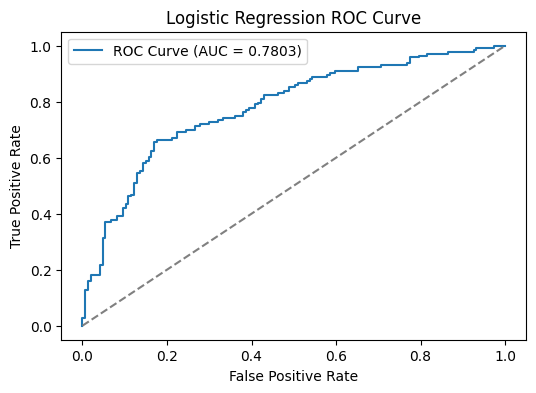

In [276]:
# Predictions and Evaluation metrics

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability for positive class

# Classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.show()

## Multiple models

In [ ]:
#Define functions


def preprecessing():
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    get_preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, cat_cols)
        ]
    )
    return get_preprocessor

def pipelines(preprocessor):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
    }

    get_pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor),
                                    ('model', model)]) 
                for name, model in models.items()}
    return get_pipelines


def prep_data(month_predict):
    X = df_final[df_final['month'] == month_predict]
    y = df_final[df_final['month'] == month_predict][target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

#--------------------------------------

results = []
months = ['2025-01-01','2025-02-01','2025-03-01']

for m in months:
    X_train, X_test, y_train, y_test = prep_data(m)
    get_preprocessor = preprecessing()
    get_pipelines = pipelines(preprocessor)


    for name, pipeline in get_pipelines.items():
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline['model'], "predict_proba") else None
        
        results.append({
            "Month": m,
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
        })


df_results = pd.DataFrame(results)

df_avg_results = df_results.groupby("Model")[["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]].mean().round(3)

styled_df = (
    df_avg_results.style
    .background_gradient(cmap="Blues", axis=0) 
    .format("{:.3f}")
)

display(styled_df)

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Decision Tree,0.763,0.767,0.744,0.755,0.762
Gradient Boosting,0.796,0.846,0.714,0.774,0.879
Logistic Regression,0.734,0.731,0.726,0.728,0.804
Random Forest,0.796,0.833,0.729,0.777,0.884
SVM,0.671,0.655,0.692,0.673,0.745


🏆 **Best Model Choices**

- Overall Best: Random Forest → strongest across all metrics, best ROC-AUC.

- If you’re designing high-cost retention campaigns, aim for high precision (minimize False positives): Gradient Boosting, Random Forest.

- If you’re doing mass low-cost engagement (emails, app notifications), recall needs to be prioritized (minimize False negatives). Decision Tree is the best model.

- If unsure, optimize F1 for balance (Gradient Boosting, Random)

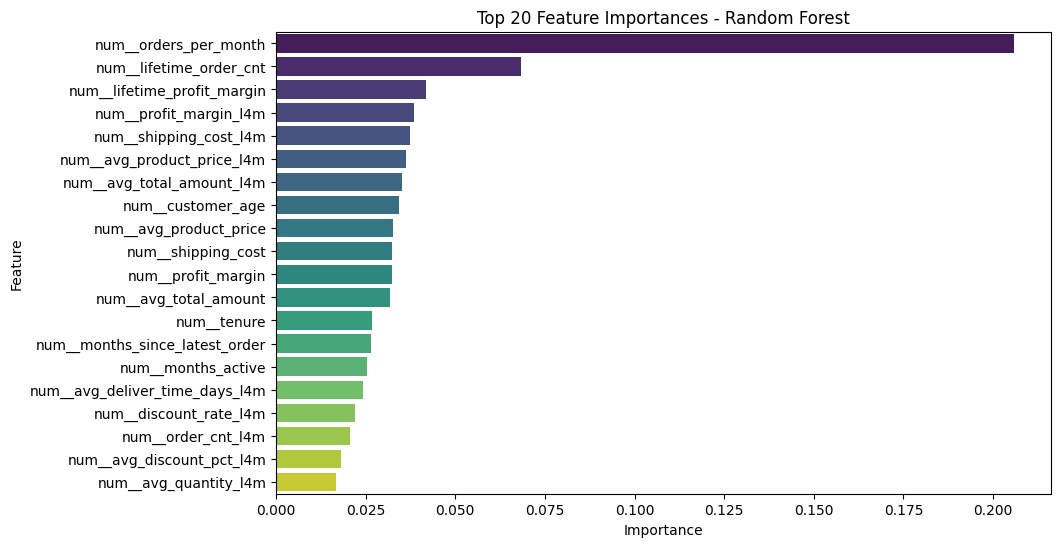

In [ ]:
# Festure Importance
best_model = get_pipelines["Random Forest"]
best_model.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (
    best_model.named_steps['preprocessor']
    .get_feature_names_out()
)

importances = best_model.named_steps['model'].feature_importances_


feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(20), palette="viridis")
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()


As expected in the analysis, lifetime values and the latest 4 months values have higher importance in the model:

- Lifetime values (e.g., total orders, total spend, lifetime frequency) are long-term, stable indicators of customer behavior. They capture how valuable a customer has been historically, so the model sees them as strong predictors of future actions.

- Latest 4 months values reflect recent engagement — recency is one of the strongest signals in customer modeling. Customers who bought recently are more likely to stay active or buy again.

So the model naturally gives higher importance to:

- Lifetime metrics → stability / baseline customer value

- Recent metrics → recency & momentum effects

=> This matches the RFM principle (Recency, Frequency, Monetary):

- Recency → last 4 months values

- Frequency/Monetary → lifetime totals

# Next steps

**1. Model Improvements**

Although the model demonstrates reasonably good precision and recall, there are opportunities for further improvement:

- Feature Engineering: Incorporate additional metrics, such as upper-funnel metrics (e.g., app engagement, conversion rate) or time-series features, to better capture user behavior.

- Ensemble Methods: Explore stacking models (e.g., Random Forest + Decision Tree) to leverage strengths of different algorithms and improve predictive performance.

**2. Experimentation**

For some businesses, speed (velocity) may matter more than absolute precision. Therefore, it may be beneficial to test the baseline model before fully optimizing it. An example of an experiment design:

| **Component**                   | **Description**                                                                                                                                                                            |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Hypothesis**                  | The model improves ROI compared to the baseline (control) segment by effectively preventing churn.                                                                                         |
| **Groups**                      | Target customers are split into two balanced segments: Control receives mass retention promotion; Treatment only targets customers predicted as “likely to churn” for retention promotion. |
| **Success Metrics**             | Primary (P0): ROI (Users/dollars), target +10% improvement; Secondary (P1, P2): Promotion conversion rate, Profit per user; Guardrail: Monitor churn rate to ensure no adverse effect.     |
| **Other Conditions (Optional)** | Consider segmenting by region or other business-relevant factors.                                                                                                                          |
| **Timeline**                    | Define based on business cycle and expected impact.                                                                                                                                        |



**3. Operations**

Once the model’s performance is validated:

- Deployment: Generate daily churn probability scores and segment users for targeted retention actions.

- Pipeline & Monitoring: Establish an automated pipeline to update churn rates and monitor model performance over time, ensuring continuous improvement.